
# BERT NSP

In [0]:
!pip install pytorch-pretrained-bert
# !pip install -U fastparquet

     |████████████████████████████████| 133kB 3.4MB/s 
     |████████████████████████████████| 655kB 55.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/35/e4/80/abf3b33ba89cf65cd262af8a22a5a999cc28fbfabea6b38473
Successfully built regex


In [1]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip -q 'drive/My Drive/Colab Notebooks/data/multi_cased_L-12_H-768_A-12.zip' -d multi_cased_L-12_H-768_A-12/

## Import

In [0]:
import os
import re
import time
import pandas as pd
import numpy as np
# from apex import amp  # for distributed training in Pytorch
from tqdm import tqdm, tqdm_notebook

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, roc_auc_score, average_precision_score,
    f1_score, classification_report)

import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# import psutil
# from multiprocessing import Pool

# NUM_CORES = psutil.cpu_count()  # number of cores on your machine
# print('number of cores:', NUM_CORES)

# def df_parallelize_run(df, func, num_partitions=20):
#     df_split = np.array_split(df, num_partitions)
#     pool = Pool(NUM_CORES)
#     df = pd.concat(pool.map(func, df_split))
#     #df = sp.vstack(pool.map(func, df_split), format='csr') faster and mem efficient for
#     pool.close()
#     pool.join()
#     return df

In [ ]:
print('Pytorch Version: {}'.format(torch.__version__))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')
if torch.cuda.device_count() > 0:
    print('Found GPU at: {}'.format(torch.cuda.get_device_name(0)))

print(os.listdir('multi_cased_L-12_H-768_A-12/'))

In [0]:
# Helpers
from sklearn import metrics
from inspect import signature

def print_results(actual, pred):
    y_preds = (pred > 0.5).astype(int)
    print('Confusion matrix:')
    print(metrics.confusion_matrix(actual, y_preds))
    print('Accuracy: {:.2f}%'.format(metrics.accuracy_score(actual, y_preds) * 100))
    print('Precision: {:.2f}%'.format(metrics.precision_score(actual, y_preds) * 100))
    print('Recall: {:.2f}%'.format(metrics.recall_score(actual, y_preds) * 100))
    print('F1 score: {:.2f}%'.format(metrics.f1_score(actual, y_preds) * 100))


# ROC(tpr-fpr) curve
def plot_roc_curve(actual, pred):
    """Plot ROC."""
    fpr, tpr, _ = metrics.roc_curve(actual, pred)

    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC AUC = {:.4f}'.format(
        metrics.roc_auc_score(actual, pred)))
    return fig


# Precision-recall curve
def plot_pr_curve(actual, pred):
    """Plot PR curve."""
    precision, recall, _ = metrics.precision_recall_curve(actual, pred)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    fig, ax = plt.subplots()
    ax.step(recall, precision, color='b', alpha=0.2, where='post')
    ax.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Avg precision = {:.4f}'.format(
        metrics.average_precision_score(actual, pred)))
    return fig

In [0]:
# Add the Bert Pytorch repo to the PATH
# using files from: https://github.com/huggingface/pytorch-pretrained-BERT

from pytorch_pretrained_bert import (
    convert_tf_checkpoint_to_pytorch,
    BertConfig,
    BertTokenizer,
    BertForNextSentencePrediction,
    BertAdam)

# Translate model from tensorflow to pytorch
BERT_MODEL_PATH = 'multi_cased_L-12_H-768_A-12/multi_cased_L-12_H-768_A-12/'
WORK_DIR = './'

if not 'pytorch_model.bin' in os.listdir(WORK_DIR):
    convert_tf_checkpoint_to_pytorch.convert_tf_checkpoint_to_pytorch(
        BERT_MODEL_PATH + 'bert_model.ckpt',
        BERT_MODEL_PATH + 'bert_config.json',
        WORK_DIR + 'pytorch_model.bin')

if not 'bert_config.json' in os.listdir(WORK_DIR)
    import shutil
    shutil.copyfile(
        BERT_MODEL_PATH + 'bert_config.json',
        WORK_DIR + 'bert_config.json')

# This is the Bert configuration file
bert_config = BertConfig(WORK_DIR + 'bert_config.json')

Building PyTorch model from configuration: {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "type_vocab_size": 2,
  "vocab_size": 119547
}

Converting TensorFlow checkpoint from /content/multi_cased_L-12_H-768_A-12/multi_cased_L-12_H-768_A-12/bert_model.ckpt
Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma with shape [768]
Loading TF weight bert/embeddings/position_embeddings with shape [512, 768]
Loading TF weight bert/embeddings/token_type_embeddings with shape [2, 768]
Loading TF weight bert/embeddings/word_embeddin

## Data preprocessing

In [0]:
df = pd.read_csv('articles_videos.csv')
df['target'] = (df['target'] > 0.2).astype(int)
df.head()

,articleTitle,videoTitle,target
0,10 Kata Bahasa Malaysia yang Mirip Indonesia ...,[Millenniask] Indonesia Darurat Toleransi? | E...,0
1,10 Rekomendasi Penginapan di Garut Cocok untu...,Jalur Baru Pendakian Gunung Papandayan,0
2,3.700 Hektar Lahan dan Hutan di Riau Terbakar,Pemkot Dumai Tetapkan Status Siaga Darurat Keb...,0
3,4 Mitos Tentang Teh yang Anda Harus Tahu Hala...,"Bertualang di Segarnya Kebun Teh ""Legendaris"" ...",0
4,5 Smartphone Terbaik Buat Kamu yang Suka Vide...,Gadis Berjenggot Pecahkan Rekor Dunia,0


In [0]:
train_examples, val_examples = train_test_split(
    df.values, test_size=0.2, random_state=0)

train_articles = train_examples[:,0],
train_videos = train_examples[:,1]
y_train = train_examples[:,2].astype(int)

val_articles = val_examples[:,0]
val_videos = val_examples[:,1]
y_val = val_examples[:,2].astype(int)
    
print("Training data size =", len(train_articles))
print("Valdiation data size =", len(val_articles))

Training data size = 24881
Valdiation data size = 6221


In [0]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, target):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.target = target


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""
    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()


def convert_sentence_pair(texts_a, texts_b, targets, max_seq_length, tokenizer):
    """Convert titles and descriptions to sentence pairs."""
    
    features = []
    for (ex_index, (text_a, text_b, target)) in enumerate(zip(texts_a, texts_b, targets)):
        tokens_a = tokenizer.tokenize(text_a)
        tokens_b = tokenizer.tokenize(text_b)
        # Modifies `tokens_a` and `tokens_b` in place so that the total
        # length is less than the specified length.
        # Account for [CLS], [SEP], [SEP] with "- 3"
        _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if ex_index < 3:
            print("*** Example ***")
            print("tokens: %s" % " ".join([str(x) for x in tokens]))
            print("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            print("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            print("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))

        features.append(
                InputFeatures(
                    input_ids=input_ids,
                    input_mask=input_mask,
                    segment_ids=segment_ids,
                    target=1-target))
        # 0 => next sentence is the continuation, 1 => next sentence is a random sentence.
    return features


MAX_SEQUENCE_LENGTH = 200
BERT_TOKENIZER = BertTokenizer.from_pretrained(BERT_MODEL_PATH, cache_dir=None, do_lower_case=False)

In [0]:
train_features = convert_sentence_pair(
    train_articles, train_videos, y_train, MAX_SEQUENCE_LENGTH, BERT_TOKENIZER)

val_features = convert_sentence_pair(
    val_articles, val_videos, y_val, MAX_SEQUENCE_LENGTH, BERT_TOKENIZER)

*** Example ***
tokens: [CLS] Ka ##sus Mei ##kar ##ta , Ter ##ident ##if ##ikasi Se ##jum ##lah Anggota DP ##RD Di ##bia ##yai Pl ##esi ##ran ke Thailand Hala ##man all - Kom ##pas . com [SEP] KP ##K Per ##iks ##a Bu ##pati Non ##akt ##if Be ##kasi Dalam Ka ##sus Mei ##kar ##ta [SEP]
input_ids: 101 25444 16824 18087 15190 10213 117 65272 99062 13918 86226 11045 49796 16254 92045 68659 84444 12944 14345 66988 48932 17582 12111 11163 19621 58892 10589 10435 118 106306 20084 119 10212 102 110468 11733 11982 40670 10113 11916 33399 14890 45522 13918 14321 37997 17157 25444 16824 18087 15190 10213 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

## Train model

In [0]:
def evaluate_model(model, val_dataloader):
    val_loss = 0
    nb_val_steps = 0
    y_true = []
    y_prob = []
    for batch in tqdm_notebook(val_dataloader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, segment_ids, target = batch

        with torch.no_grad():
            loss = model(input_ids, segment_ids, input_mask, target)
            logits = model(input_ids, segment_ids, input_mask, next_sentence_label=None)
        
        val_loss += loss.item()
        nb_val_steps += 1
        
        y_prob.extend(F.softmax(logits, dim=1)[:, 0].detach().cpu().numpy().tolist())
        y_true.extend(target.to('cpu').numpy().tolist())
    
    val_loss /= nb_val_steps
    print('Val loss = {}'.format(val_loss))
    
    y_true = 1 - np.array(y_true)  # positive = 0
    y_pred = (np.array(y_prob) > 0.5).astype(int)
    print('Val accuracy = {}'.format(accuracy_score(y_true, y_pred)))
    print('Val AUC = {}'.format(roc_auc_score(y_true, y_prob)))
    print('Val avg precision = {}'.format(average_precision_score(y_true, y_prob)))
          
    return np.array(y_prob)

In [0]:
def get_dataloader(data_features, shuffle=False, drop_last=False):
    """Output dataloader."""
    data_input_ids = torch.tensor(
        [f.input_ids for f in data_features], dtype=torch.long)
    data_input_mask = torch.tensor(
        [f.input_mask for f in data_features], dtype=torch.long)
    data_segment_ids = torch.tensor(
        [f.segment_ids for f in data_features], dtype=torch.long)
    data_target = torch.tensor(
        [f.target for f in data_features], dtype=torch.long)
    data_dataset = torch.utils.data.TensorDataset(
        data_input_ids, data_input_mask, data_segment_ids, data_target)
    data_dataloader = torch.utils.data.DataLoader(
        data_dataset, batch_size=BATCH_SIZE, shuffle=shuffle, drop_last=drop_last)
    return data_dataloader


def train_model(train_features, val_features):
    """Train model."""
    model = BertForNextSentencePrediction.from_pretrained(
        WORK_DIR, cache_dir=None)
    model.zero_grad()
    model.to(device)
    
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0}
    ]

    num_train_optimization_steps = int(
        EPOCHS * len(train_features) / BATCH_SIZE / ACCUMULATION_STEPS)

    optimizer = BertAdam(optimizer_grouped_parameters,
                         lr=LR,
                         warmup=WARMUP,
                         t_total=num_train_optimization_steps)

    train_dataloader = get_dataloader(train_features, shuffle=True, drop_last=True)
    val_dataloader = get_dataloader(val_features)
    
    for epoch in range(EPOCHS):
        # TRAIN loop
        model.train()
        
        tr_loss = 0
        nb_tr_steps = 0
        for step, batch in tqdm_notebook(enumerate(train_dataloader), total=len(train_dataloader), leave=False):
            batch = tuple(t.to(device) for t in batch)
            input_ids, input_mask, segment_ids, target = batch
            # forward pass
            loss = model(input_ids, segment_ids, input_mask, target)
            if ACCUMULATION_STEPS > 1:
                loss = loss / ACCUMULATION_STEPS

            # backward pass
            loss.backward()

            tr_loss += loss.item()
            nb_tr_steps += 1

            # update parameters
            if (step + 1) % ACCUMULATION_STEPS == 0:
                optimizer.step()
                optimizer.zero_grad()
            
        print("Train loss = {}".format(tr_loss / nb_tr_steps))
                
        # VALIDATION on validation set
        model.eval()
        _ = evaluate_model(model, val_dataloader)
        
    # Save model artefacts
    torch.save(model.state_dict(), OUTPUT_MODEL_FILE)
    return None


OUTPUT_MODEL_FILE = "bert_sent.bin"

EPOCHS = 2
BATCH_SIZE = 32
LR = 2e-5
WARMUP = 0.1
ACCUMULATION_STEPS = 1


train_model(train_features, val_features)

Train loss = 0.11433761414413747



Val loss = 0.08607688867128813
Val accuracy = 0.9823179553126506
Val AUC = 0.6834285416759643
Val avg precision = 0.055562689821447915


Train loss = 0.08452886377522384



Val loss = 0.08859767717046615
Val accuracy = 0.9823179553126506
Val AUC = 0.6847339373112569
Val avg precision = 0.05872038515857137


In [0]:
# !cp bert_sent.bin 'drive/My Drive/Colab Notebooks/data/bert_sent.bin'

## Validation

In [0]:
# Run validation
model = BertForNextSentencePrediction(bert_config)
model.load_state_dict(torch.load(OUTPUT_MODEL_FILE))

BATCH_SIZE = 32
# model = BertForNextSentencePrediction.from_pretrained(WORK_DIR, cache_dir=None)

model.to(device)

for param in model.parameters():
    param.requires_grad = False
model.eval()

BertForNextSentencePrediction(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermedia

In [0]:
val_dataloader = get_dataloader(val_features)
y_prob = evaluate_model(model, val_dataloader)

Val loss = 0.06608640712996323
Val accuracy = 0.9898730107699727
Val AUC = 0.6522755916109929
Val avg precision = 0.03854543099475151


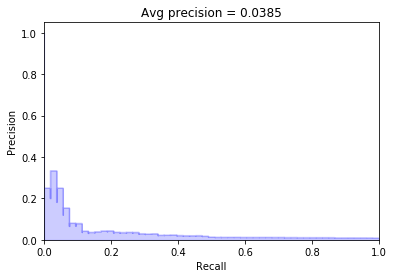

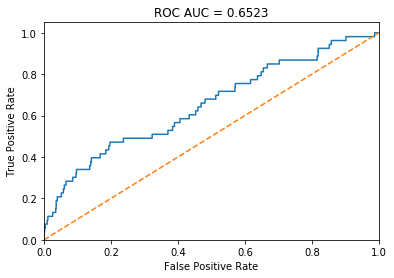

In [0]:
plot_pr_curve(y_val, y_prob)
plt.show()

plot_roc_curve(y_val, y_prob)
plt.show()

## Serve

In [0]:
# model = BertForNextSentencePrediction(bert_config)
# model.load_state_dict(torch.load(OUTPUT_MODEL_FILE))

BATCH_SIZE = 32
model = BertForNextSentencePrediction.from_pretrained(WORK_DIR, cache_dir=None)

model.to(device)

for param in model.parameters():
    param.requires_grad = False
model.eval()

In [0]:
test_features = convert_sentence_pair(
    test_titles, test_descs, MAX_SEQUENCE_LENGTH, BERT_TOKENIZER)

*** Example ***
tokens: [CLS] US Congress to present Congressional Gold Medal in honor of Filipino W ##W ##II vet ##s [SEP] The US House and Senate will present on Wednesday a Congressional Gold Medal in honor of Filipino veterans who served during World War II . One Congressional Gold Medal will be given collective ##ly to the Filipino veterans , as per Public Law No . : 114 - 265 , " in recognition of the dedicated service of the veterans during World War II . " A total of 260 , 000 Filipino and Filipino - American soldiers fought from July 1941 to December 1946 during World War II for the Philippines and the US . It was US President Franklin D . Roosevelt who " called all organized military forces of the Philippines into the service of the United States , " according to a press release issued by the press office of House Speaker Paul Ryan . " Their bra ##ver ##y , hero ##ism , and dedicat ##ion played an integral part in leading Allied powers to victory over Nazi and fa ##sci ##st f

In [0]:
for i in range(len(test_examples)):
    for j in range(len(test_examples)):
        if i != j:
            test_features[i*len(test_examples)+j].target = 1

In [0]:
test_dataloader = get_dataloader(test_features)
y_prob = evaluate_model(model, test_dataloader)

y_prob = np.array(y_prob).reshape(len(test_examples), len(test_examples))

In [0]:
idx = 7
print(test_examples[idx, 0])
best_idx = y_prob[idx].argsort()[-3:][::-1]
for k in best_idx:
    print(y_prob[idx, k], test_examples[k, 1])
    
print()
best_idx = y_prob[idx].argsort()[:3][::-1]
for k in best_idx:
    print(y_prob[idx, k], test_examples[k, 1])

Duterte visits Joanna Demafelis’ wake, vows justice
0.9925883412361145 President Rodrigo Duterte announced on Friday that the suspension of deployment of Filipino workers to Kuwait would continue after a dead Filipino woman was found in a freezer at an abandoned apartment in the Gulf state. "We do not intend to offend any government or anyone. But if a ban is what is needed, then let it be so," Duterte said at a press conference in Davao City. Duterte deplored the death of Joanna Daniela Demafelis as he appealed to Arab nations to treat Filipino workers with dignity and respect. "The Filipino is no slave to anyone, anywhere and everywhere. Every unlawful physical injury that is inflicted on an OFW [overseas Filipino worker] is an injury [that] I personally bear as the head of this Republic," Duterte said. "Every abuse committed against an OFW is an affront against us, as a sovereign nation. [All that] I ask [for] our overseas Filipino workers, is that their dignity is honored and the r